In [7]:
import os
import numpy as np
import pandas as pd
import hypertools as hyp
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as sw

from helpers import load_data as load
from helpers import wipe_formatting, cleanup_text

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeremy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# download data

data_filepath = 'data/data.csv'
data_fid = '1hCCn31z4HM4IzQi59DP-vvUpYKhlvo2S'

# download and load data
data = load(data_filepath, data_fid)

downloading data...
loading data...


In [3]:
data.head()

,id,title,url,writers,genres,script
0,1,10 Things I Hate About You,http://www.imsdb.com/scripts/10-Things-I-Hate-...,Karen McCullah Lutz;Kirsten Smith;William Shak...,Comedy;Romance,\n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...
1,2,12,http://www.imsdb.com/scripts/12.html,Lawrence Bridges,Comedy,\n\n \n 12 - Script\n
2,3,12 and Holding,http://www.imsdb.com/scripts/12-and-Holding.html,Anthony Cipriano,Drama,\n \n \n ...
3,4,12 Monkeys,http://www.imsdb.com/scripts/12-Monkeys.html,David Peoples;Janet Peoples,Drama;Sci-Fi;Thriller,\n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...
4,5,12 Years a Slave,http://www.imsdb.com/scripts/12-Years-a-Slave....,John Ridley,Drama,\r\n\r\n\r\n 12 YE...


In [138]:
n_topics = 200
video_wsize = 50 # sentences 

# vectorizer parameters
vectorizer_params = {
    'stop_words' : sw.words('english'),
    'max_df' : 0.2,
    'min_df' : 0.05    
}

# topic model parameters
semantic_params = {
    'n_components' : n_topics,
    'learning_method' : 'batch',
    'random_state' : 0,    
}

In [14]:
def robust_cleaner(txt):
    try:
        return cleanup_text(wipe_formatting(txt))
    except:
        return ''

In [15]:
cleaned_scripts = data['script'].apply(robust_cleaner)

In [20]:
corpus = cleaned_scripts.values.tolist()

In [49]:
characters = pd.read_csv('data/act_to_char.csv')

In [50]:
characters.head()

,Unnamed: 0,act,char,title
0,0,Heath Ledger,Patrick Verona,10 Things I Hate About You
1,1,Julia Stiles,Katarina Stratford,10 Things I Hate About You
2,2,Joseph Gordon-Levitt,Cameron James,10 Things I Hate About You
3,3,Larisa Oleynik,Bianca Stratford,10 Things I Hate About You
4,4,David Krumholtz,Michael Eckman,10 Things I Hate About You


In [60]:
chars = []
for c in characters['char'].values:
    chars.extend(str.lower(c).split())

In [139]:
vectorizer_params['stop_words'].extend(chars)
cv = CountVectorizer(**vectorizer_params)
counts = cv.fit_transform(corpus)

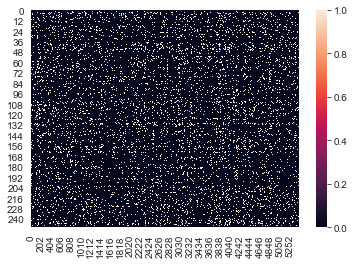

In [140]:
sns.heatmap(counts[:250, :].todense() > 0)

In [141]:
lda = LatentDirichletAllocation(**semantic_params)
lda.fit(counts)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=200, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [142]:
weights = lda.components_.copy()
words = cv.get_feature_names()

def get_top_words(model, vocab, n_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):       
        next = topic.argsort()[:-n_words - 1:-1]
        next_words = list(map(lambda x: vocab[x], next))
        top_words.append(next_words)
        print(f'TOPIC {topic_idx}: {", ".join(next_words)}')
    return top_words

top_words = get_top_words(lda, words, 10)

TOPIC 0: devils, haul, os, fuel, agents, magnum, duct, creek, compartment, disk
TOPIC 1: films, subtitled, detectives, yup, assembly, label, trains, hm, planes, tomb
TOPIC 2: lyrics, armchair, documents, residence, napkin, banana, bending, dresses, contract, hmm
TOPIC 3: sams, moms, bracelet, binoculars, scissors, serial, ms, gum, omitted, interstate
TOPIC 4: aone, prisoners, fuse, mph, ta, wolves, timber, cheesy, omitted, debt
TOPIC 5: binoculars, vo, alleyway, imagination, via, cats, tourists, creak, bricks, paintings
TOPIC 6: splinter, generals, settlement, cells, gauntlet, predator, clicking, lair, survivors, chains
TOPIC 7: judges, missiles, presidents, planes, lapse, bodyguards, spectators, stake, vote, pigs
TOPIC 8: jews, germans, stamps, onest, prisoners, poles, tin, twond, shells, attic
TOPIC 9: stew, cellar, reckon, residence, chevy, canal, ye, yall, typewriter, cruising
TOPIC 10: manhattan, beeps, hover, captains, cube, thugs, screens, chute, ribbon, bowed
TOPIC 11: rusty, f

In [143]:
movie_topics = lda.transform(counts)

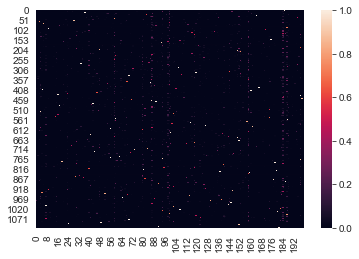

In [144]:
sns.heatmap(movie_topics)

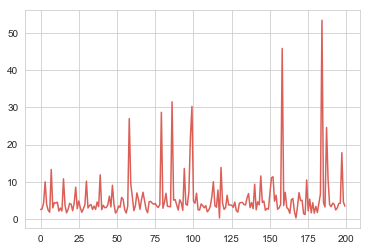

In [145]:
plt.plot(np.sum(movie_topics, axis=0))

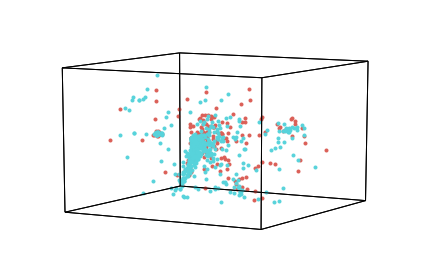

In [146]:
hyp.plot(movie_topics, '.', hue=data['genres'].apply(lambda x: 'comedy' in x.lower()), ndims=3, reduce='SpectralEmbedding')

In [147]:
def get_windows(transcript, wsize=video_wsize):
    cleaned = cleanup_text(wipe_formatting(transcript))
    text_list = cleaned.split('.')
    video_w = []
    
    for ix, sentence in enumerate(text_list):
        video_w.append(' '.join(text_list[ix:ix+wsize]))
        
    return video_w

In [148]:
def video_trajectory(transcript, wsize=video_wsize):
    windows = get_windows(transcript, wsize=wsize)
    counts = cv.transform(windows)
    return lda.transform(counts)

In [161]:
trajectories = list(map(video_trajectory, corpus[:10]))

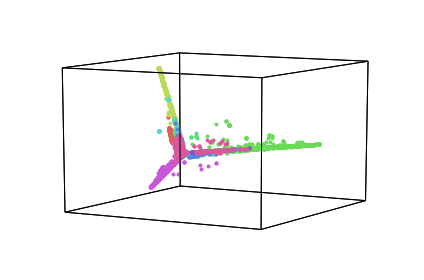

In [166]:
hyp.plot(trajectories, '.')